In [1]:
%load_ext autoreload
%autoreload 2

In [88]:
import os, sys
import glob
import warnings
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

import skimage

from fastai.vision import *

from utils.databunch import get_data_bunch

In [3]:
data_df = pd.read_csv('./data/train.csv')
data_df

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN
5,00031f466.jpg_2,NaN
6,00031f466.jpg_3,NaN
7,00031f466.jpg_4,NaN
8,000418bfc.jpg_1,NaN
9,000418bfc.jpg_2,NaN


## Mask Generation

In [9]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )

In [10]:
for i in range(0,len(data_df),4):
    r1 = data_df['EncodedPixels'][i]
    r2 = data_df['EncodedPixels'][i+1]    
    r3 = data_df['EncodedPixels'][i+2]    
    r4 = data_df['EncodedPixels'][i+3]
    if (pd.isnull(r1)+pd.isnull(r2)+pd.isnull(r3)+pd.isnull(r4)) < 2:
        print(i)

43212
47104


In [11]:
def addmask(fullmask, rle, def_id):
    rle = '' if pd.isnull(rle) else rle
    mask = rle2mask(rle, (256, 1600, 3))
    assert(fullmask[mask!=0].sum() == 0)
    fullmask[mask!=0] = def_id
    return fullmask

In [12]:
plt.figure(figsize=(16,8))
for i in tqdm(range(0, len(data_df), 4)):
#     i=47104
    id = data_df.loc[i, 'ImageId_ClassId'].replace('.jpg', '')
    img = io.imread('./data/train_images/' + id[:-2] + '.jpg')
#     plt.imshow(img)
#     print(img.shape)
    mask = np.zeros(img.shape[:-1], dtype='uint8')
    mask = addmask(mask, data_df.loc[i, 'EncodedPixels'], 1)
    mask = addmask(mask, data_df.loc[i+1, 'EncodedPixels'], 2)
    mask = addmask(mask, data_df.loc[i+2, 'EncodedPixels'], 3)
    mask = addmask(mask, data_df.loc[i+3, 'EncodedPixels'], 4)
    
    readmask = io.imread('./data/train_masks/' + id[:-2] + '.png', mask)
    assert(np.array_equal(mask, readmask))

#     print(mask.sum())
#     plt.imshow(mask, alpha=0.2)
#     break
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         io.imsave('./data/train_masks/' + id[:-2] + '.png', mask)

<Figure size 1152x576 with 0 Axes>

## Dataset

In [62]:
split_df = pd.read_csv('./data/split.csv')
# valid_files = set(split_df[split_df['is_valid'] == True]['ImageId_ClassId'])

In [66]:
split_df

,ImageId_ClassId,1,2,3,4,is_valid
0,0002cc93b.jpg,1,0,0,0,False
1,00031f466.jpg,0,0,0,0,False
2,000418bfc.jpg,0,0,0,0,False
3,000789191.jpg,0,0,0,0,False
4,0007a71bf.jpg,0,0,1,0,False
5,000a4bcdd.jpg,1,0,0,0,True
6,000f6bf48.jpg,0,0,0,1,False
7,0014fce06.jpg,0,0,1,0,True
8,001982b08.jpg,0,0,0,0,False
9,001d1b355.jpg,0,0,0,0,False


In [84]:
train_data_paths, valid_data_paths, train_label_paths, valid_label_paths = [], [], [], []
for i in range(len(split_df)):
    data_path = Path('./data/train_images/' + split_df.loc[i, 'ImageId_ClassId']) 
    label_path = Path('./data/train_masks/' + split_df.loc[i, 'ImageId_ClassId'].replace('.jpg', '.png'))
    if split_df.loc[i, 'is_valid']:
        valid_data_paths.append(data_path)
        valid_label_paths.append(label_path)
    else:
        train_data_paths.append(data_path)
        train_label_paths.append(label_path)
print(len(train_data_paths), len(valid_data_paths))

10054 2514


In [89]:
skimage.io.imread('./data/train_masks/0101e2cf0.png').shape

(256, 1600)

In [204]:
get_transforms()

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

In [286]:
data = get_data_bunch(split_df)
data

ImageDataBunch;

Train: LabelList (70378 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: .;

Valid: LabelList (17598 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: .;

Test: None

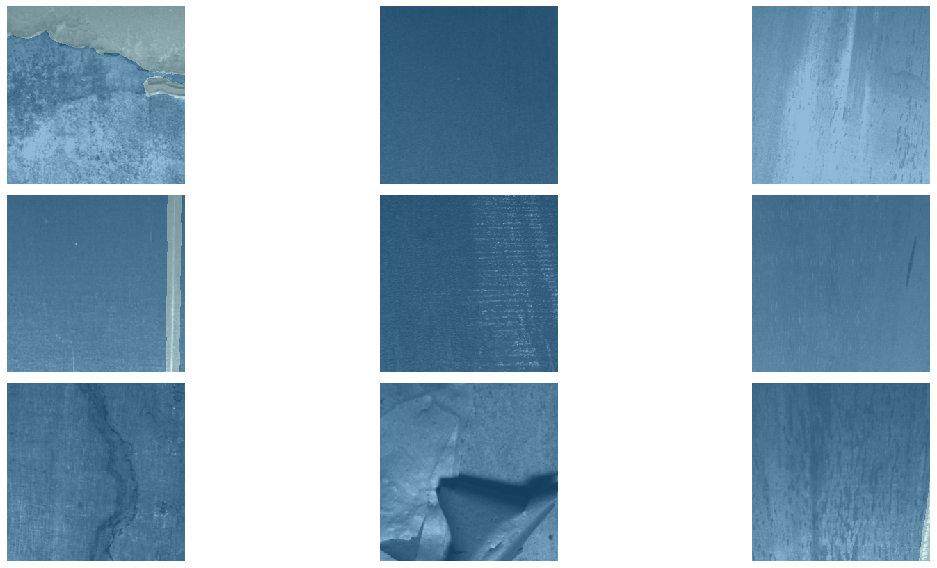

In [289]:
data.show_batch(rows=3, figsize=(18,8))

In [11]:
globals()['mxresnet']

<module 'models.mxresnet' from '/home/litemax/kaggle/severstal-steel/models/mxresnet.py'>

In [6]:
Net = getattr(model_list, 'mxresnet18')

In [7]:
Net()

functools.partial(<function mxresnet at 0x7f7176904378>, expansion=1, n_layers=[2, 2, 2, 2], name='mxresnet18')

### Image Crops

In [224]:
img = skimage.io.imread('./data/train_images/030336aa4.jpg')

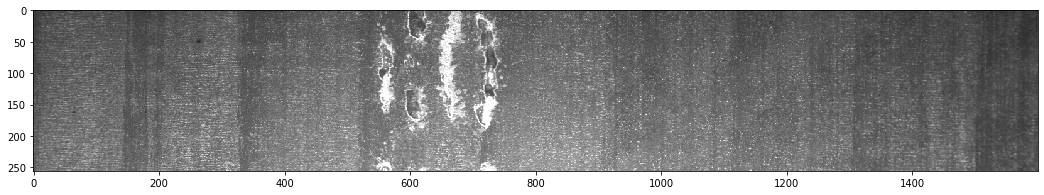

In [225]:
plt.figure(figsize=(18,6))
plt.imshow(img)

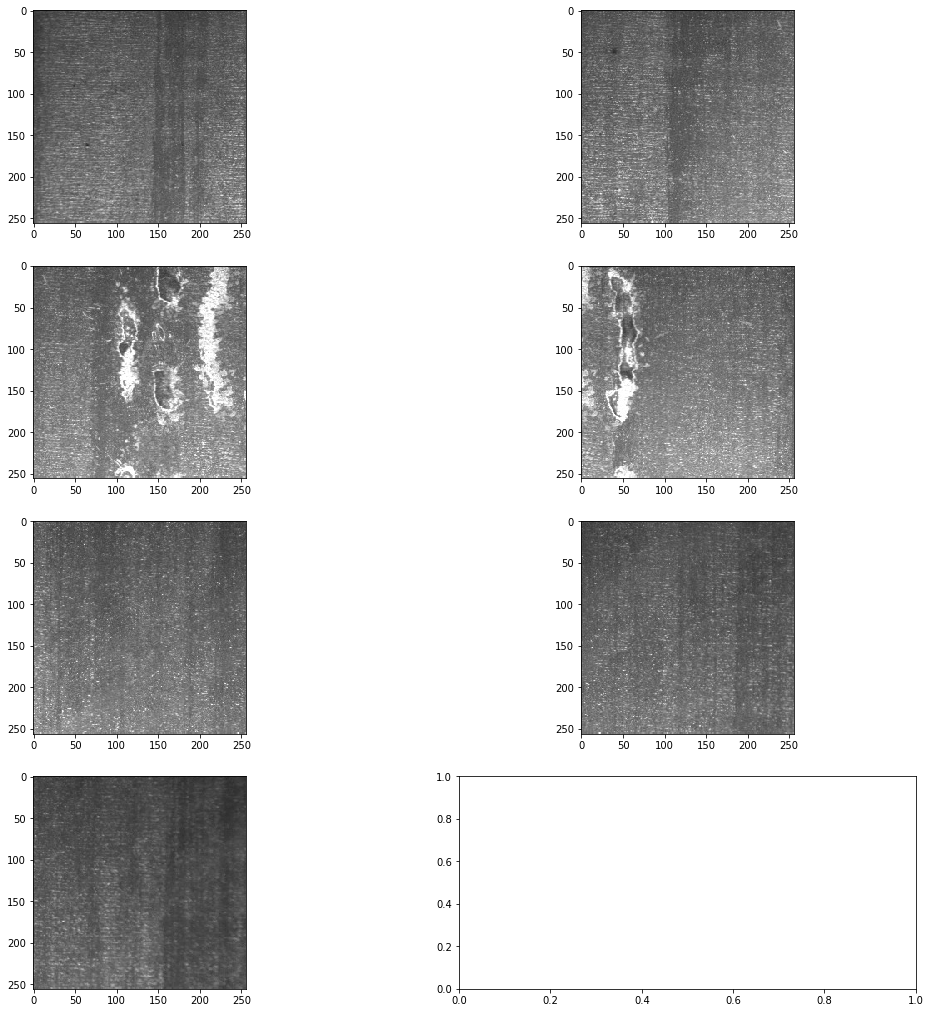

In [226]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(18,18))
for i, idx in enumerate(range(0, 1600-256+32, 256-32)):
#     print(i, i+256)
    ax[i//2, i%2].imshow(img[:, idx:idx+256, :])

In [227]:
a = glob.glob('./data/train_images/*_c*.jpg')

./data/train_images/b98f3f3b7_c4.jpg


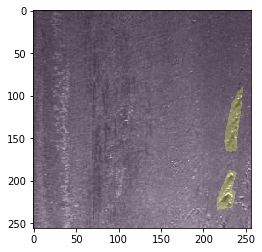

In [264]:
idx = 958
print(a[idx])
plt.imshow(skimage.io.imread(a[idx]))
plt.imshow(skimage.io.imread(a[idx].replace('train_images', 'train_masks').replace('.jpg', '.png')), alpha=0.2)

./data/train_images/b98f3f3b7_c4.jpg


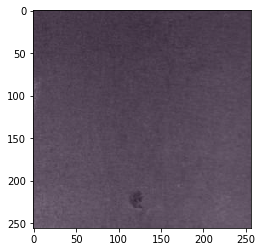

In [268]:
idx = 958
print(a[idx])
plt.imshow(skimage.io.imread('./data/train_images/b98f3f3b7_c6.jpg'))
plt.imshow(skimage.io.imread('./data/train_masks/b98f3f3b7_c6.png'), alpha=0.2)

./data/train_images/6ecfb9df5_c3.jpg


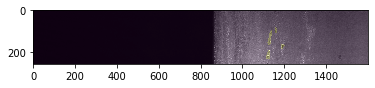

In [262]:
idx = 93
print(a[idx])
plt.imshow(skimage.io.imread('./data/train_images/b98f3f3b7.jpg'))
plt.imshow(skimage.io.imread('./data/train_masks/b98f3f3b7.png'), alpha=0.2)